# GROUP PROJECT - RECOMMENDATION TOOLS 2022

#### BY 
#### -  HARIKRISHNAN GOPALAKRISHNAN, SWASTHIK VELLINGIRI KOWSALYA

### Loading Packages

In [240]:
import sys
sys.path.append("../IESEGRecSys/IESEGRecSys")
import eval
from model import ContentBased
import numpy as np
import pandas as pd
import nltk 
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from surprise import KNNBasic, SVD, CoClustering, Dataset, Reader, SVDpp, KNNBasic, KNNWithMeans, KNNBaseline 
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import BaselineOnly
from surprise import NMF
from model import ContentBased
from surprise import accuracy
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\svellingirikowsalya\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\svellingirikowsalya\AppData\Roaming\nltk_data
[nltk_data]     ...
[nltk_data]   Package stopwords is already up-to-date!


### Importing Data

In [227]:
artists = pd.read_table('../Group Project/Data-20220306/Data Group Assignment/Artists.dat')
tags = pd.read_table('../Group Project/Data-20220306/Data Group Assignment/tags.dat')
ua = pd.read_table('../Group Project/Data-20220306/Data Group Assignment/user_artists.dat')
uta = pd.read_table('../Group Project/Data-20220306/Data Group Assignment/user_taggedartists.dat')

### Exploratory Data Analysis

In [228]:
#Common Artist tags in terms of artists
# merge the usertaggedartists and tags table

u_tags = pd.merge(uta, tags, how='left', on='tagID')
u_tags.head()

,userID,artistID,tagID,day,month,year,tagValue
0,2,52,13,1,4,2009,chillout
1,2,52,15,1,4,2009,downtempo
2,2,52,18,1,4,2009,electronic
3,2,52,21,1,4,2009,trip-hop
4,2,52,41,1,4,2009,female vovalists


In [229]:
ct =u_tags.groupby("artistID")["tagValue"].value_counts().rename("count")
ct = ct.reset_index()
ct = ct.groupby("artistID")
ct = ct.first()["tagValue"]

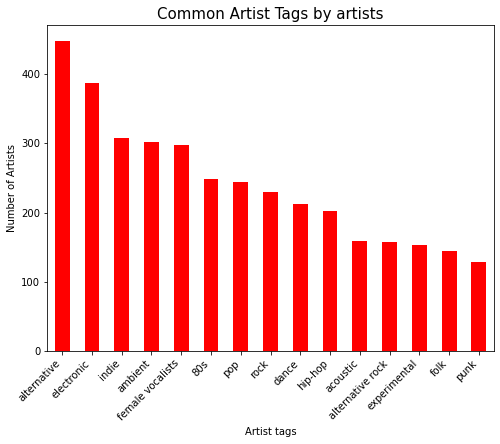

In [230]:
#PLot
fig, ax = plt.subplots(figsize=(8,6))
ct.value_counts().head(15).plot.bar(ax=ax,color='red')
plt.title("Common Artist Tags by artists", fontsize=15)
plt.xlabel("Artist tags", fontsize=10)
plt.ylabel("Number of Artists", fontsize=10)
plt.xticks(rotation=45, ha="right")
plt.show()

In [231]:
#Common Artist tags in terms of users
ct1 =u_tags.groupby("userID")["tagValue"].value_counts().rename("count")
ct1 = ct1.reset_index()
ct1 = ct1.groupby("userID")
ct1 = ct1.first()["tagValue"]

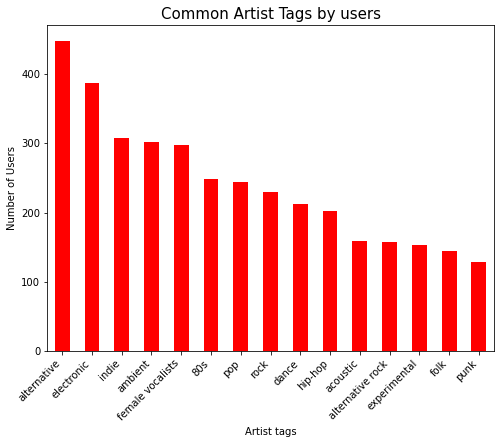

In [232]:
#PLot
fig, ax = plt.subplots(figsize=(8,6))
ct.value_counts().head(15).plot.bar(ax=ax,color='red')
plt.title("Common Artist Tags by users", fontsize=15)
plt.xlabel("Artist tags", fontsize=10)
plt.ylabel("Number of Users", fontsize=10)
plt.xticks(rotation=45, ha="right")
plt.show()

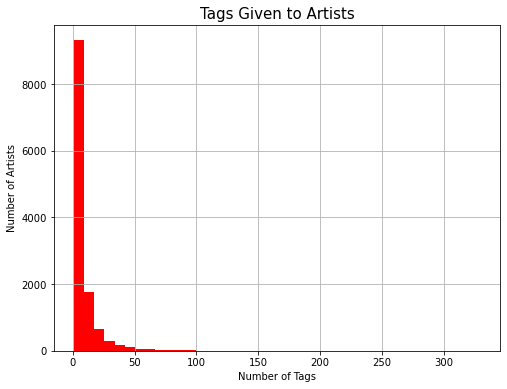

In [233]:
#Number of tags grouped by Artists
fig, ax = plt.subplots(figsize=(8, 6))
uta.groupby("artistID")["tagID"].nunique().hist(bins=40, ax=ax,color='red')
plt.title("Tags Given to Artists", fontsize=15)
plt.xlabel("Number of Tags", fontsize=10)
plt.ylabel("Number of Artists", fontsize=10)
plt.show()

In [234]:
ua_art = pd.merge(artists, ua,how='inner',left_on='id',right_on='artistID')

ua_art = ua_art[['id','name','userID','artistID','weight']]
ua_art.head()

,id,name,userID,artistID,weight
0,1,MALICE MIZER,34,1,212
1,1,MALICE MIZER,274,1,483
2,1,MALICE MIZER,785,1,76
3,2,Diary of Dreams,135,2,1021
4,2,Diary of Dreams,257,2,152


In [235]:
#Ranking the Artists in terms of Total number of plays
rank_art = (ua_art.groupby(['name']).agg({'userID':'count','weight':'sum'}).
    rename(columns={"userID":'Total_num_users',"weight":"Total_num_A.plays"}).
              sort_values(['Total_num_A.plays'],ascending=False))

rank_art['Avg_user_plays'] = rank_art['Total_num_A.plays']/rank_art['Total_num_users']

In [236]:
#Ranking the Users in terms of Total number of plays
rank_user = (ua_art.groupby(['userID']).agg({'name':'count','weight':'sum'}).
    rename(columns={"name":'Total_num_artists',"weight":"Total_num_U.plays"}).
            sort_values(['Total_num_U.plays'],ascending=False))

#Description of Artists rank data
rank_art.head(10)


,Total_num_users,Total_num_A.plays,Avg_user_plays
name,,,
Britney Spears,522,2393140,4584.559387
Depeche Mode,282,1301308,4614.567376
Lady Gaga,611,1291387,2113.563011
Christina Aguilera,407,1058405,2600.503686
Paramore,399,963449,2414.659148
Madonna,429,921198,2147.314685
Rihanna,484,905423,1870.708678
Shakira,319,688529,2158.398119
The Beatles,480,662116,1379.408333


In [237]:
rank_art.sort_values(['Total_num_users'],ascending=False).head()

,Total_num_users,Total_num_A.plays,Avg_user_plays
name,,,
Lady Gaga,611,1291387,2113.563011
Britney Spears,522,2393140,4584.559387
Rihanna,484,905423,1870.708678
The Beatles,480,662116,1379.408333
Katy Perry,473,532545,1125.887949


In [238]:
# to show values on plots
import numpy as np

# Reference
# https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values

def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = int(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = int(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

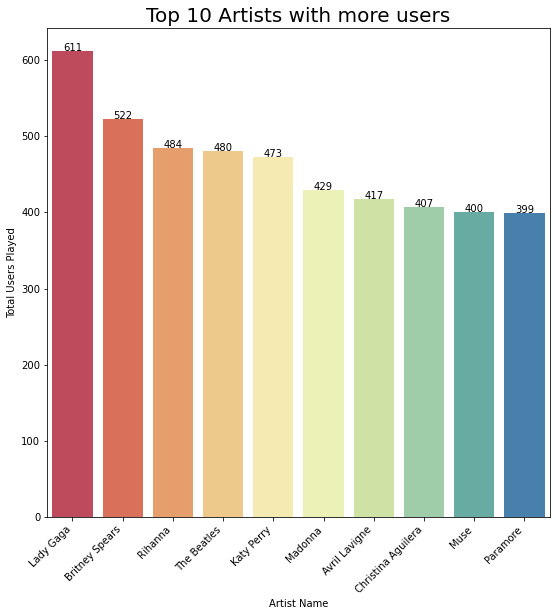

In [241]:
# Top 10 Artists with more users

fig, ax = plt.subplots(figsize = (9,9))

ra = rank_art.sort_values(['Total_num_users'],ascending=False).head(10)
x = ra.index


ax = sns.barplot(x=x, y= "Total_num_users", data = ra, palette ="Spectral", ci = None) 

plt.title('Top 10 Artists with more users', fontsize = 20)
plt.xticks(rotation=45, ha='right')
ax.set(xlabel='Artist Name', ylabel='Total Users Played')
show_values_on_bars(ax)

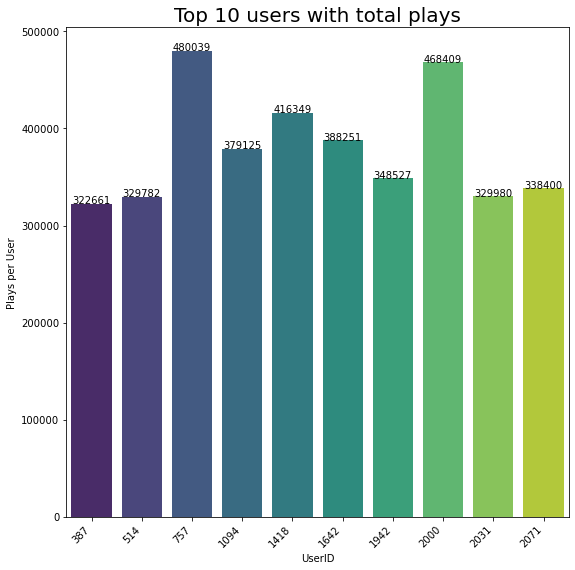

In [242]:
#Top 10 users in terms of total plays
ra2 = rank_user.sort_values(['Total_num_U.plays'],ascending=False).head(10)

fig, ax = plt.subplots(figsize = (9,9))

ra2 = rank_user.sort_values(['Total_num_U.plays'],ascending=False).head(10)

x = ra2.index


ax = sns.barplot(x=x, y= "Total_num_U.plays", data = ra2, palette ='viridis', ci = None) 

plt.title('Top 10 users with total plays', fontsize = 20)
plt.xticks(rotation=45, ha='right')
ax.set(xlabel='UserID', ylabel='Plays per User')
show_values_on_bars(ax)



### Pre - Processing Dataframes

##### Converting Continuous variable into Categorical Variable

In [42]:
# Creating a new "weight" categorical variable because the raw weight column was continuous

ua['weight1'] = pd.qcut(ua['weight'], 10,
                            labels = False)

##### Content BaseTable for content based

In [43]:
# Merging user_taggedartists and tags to create a basetable for content based recommendation

content_data_0 = pd.merge(uta,tags,how="inner",on='tagID')

##### Checking if all the user ID and Artist ID are in user_artists (For Collaborative) and Content data (For Content Based)

In [44]:
print("Number of unique userID in UTA (Content data) = " + str(content_data_0['userID'].nunique()))
print("Number of unique userID in UA (user_artists) = " + str(ua['userID'].nunique()))

Number of unique userID in UTA (Content data) = 1892
Number of unique userID in UA (user_artists) = 1892


In [45]:
print("Number of unique ArtistID in UTA (Content data) = " + str(content_data_0['artistID'].nunique()))
print("Number of unique ArtistID in UA (user_artists) = " + str(ua['artistID'].nunique()))

Number of unique ArtistID in UTA (Content data) = 12523
Number of unique ArtistID in UA (user_artists) = 17632


##### Making sure all the missing Artist ID are present in the content data

In [46]:
content_data_0.head(2)

,userID,artistID,tagID,day,month,year,tagValue
0,2,52,13,1,4,2009,chillout
1,2,63,13,1,4,2009,chillout


In [47]:
# Creating a dummy Dataframe so we could do an outer join to fill the missing artist ID

dat1 = pd.DataFrame(ua['artistID'].drop_duplicates())

content_data = pd.merge(content_data_0,dat1,on="artistID",how="right")

In [48]:
print("Number of unique ArtistID in UTA (Content data) = " + str(content_data['artistID'].nunique()))
print("Number of unique ArtistID in UA (user_artists) = " + str(ua['artistID'].nunique()))

Number of unique ArtistID in UTA (Content data) = 17632
Number of unique ArtistID in UA (user_artists) = 17632


##### Checking and cleaning NA values in the tags column which will be the content data

In [49]:
content_data['tagValue'].isna().sum()

5499

In [50]:
# Filling the NA values with a dummy string that will be removed as a stopword later in the content data preprocessing step

content_data["tagValue"] = content_data["tagValue"].fillna("a")

##### Creating one row per artist by merging all tags for an artist

In [51]:
content_data = content_data.groupby(['artistID','tagValue']).nth(0)
content_data = content_data.reset_index()
content_data['tag_value'] = content_data.groupby(['artistID'])['tagValue'].transform(lambda x : ' '.join(x))
content_data = content_data.groupby(['artistID', 'tag_value']).first().reset_index(drop = False)

In [52]:
content_data.head(2)

,artistID,tag_value,tagValue,userID,tagID,day,month,year
0,1,better than lady gaga gothic j-rock japanese j...,better than lady gaga,785.0,2850.0,1.0,8.0,2010.0
1,2,ambient dark darkwave electronic german gothic...,ambient,697.0,14.0,1.0,10.0,2007.0


In [53]:
content_data = content_data[['artistID','tag_value']]
content_data = content_data.set_index('artistID')

##### creatoing one common table to predict recommendations in the last section

In [54]:
#rename the column so it has artist ID which is same as 

artists = artists.rename(columns={"id":"artistID"})

In [55]:
# Merging user_taggedartists and artists

final = pd.merge(ua, artists, how='left', on='artistID')
final = pd.merge(content_data,artists, how='left', on='artistID')

In [56]:
final.head(2)

,artistID,tag_value,name,url,pictureURL
0,1,better than lady gaga gothic j-rock japanese j...,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
1,2,ambient dark darkwave electronic german gothic...,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg


In [57]:
# Created the lookup table for the final predictions. 

lookup_artistID = final.drop_duplicates(subset=["artistID"], keep="last").set_index("artistID")
lookup_artistID = lookup_artistID.reset_index()
lookup_artistID.head(2)

,tag_value,name,url,pictureURL
artistID,,,,
1,better than lady gaga gothic j-rock japanese j...,MALICE MIZER,http://www.last.fm/music/MALICE+MIZER,http://userserve-ak.last.fm/serve/252/10808.jpg
2,ambient dark darkwave electronic german gothic...,Diary of Dreams,http://www.last.fm/music/Diary+of+Dreams,http://userserve-ak.last.fm/serve/252/3052066.jpg


##### Preprocessing Content Data before fitting the model

In [58]:
# content based

# Tokenize, case conversion & only alphabetic

token = content_data['tag_value'].apply(lambda txt: [word.lower() for word in word_tokenize(str(txt)) if word.isalpha()])

# setup stop words list

stop_words = stopwords.words('english')
stop_words.append('nan')
stemmer = SnowballStemmer("english")

# remove stopwords, stem

token_stem = token.apply(lambda lst_token: [stemmer.stem(tok) for tok in lst_token if tok not in stop_words and len(tok) > 2])

# TFIDF vectorizer
tfidf = TfidfVectorizer()

# apply tf-idf vectorizer -> document-term-matrix in sparse format
dtm = tfidf.fit_transform([" ".join(x) for x in token_stem])

print(dtm.shape)

df_dtm = pd.DataFrame(dtm.toarray(), columns=tfidf.get_feature_names(), index=content_data.index)
df_dtm.head()

(17632, 6405)


C:\tools\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,aaaaa,aaliyah,aana,aaron,abba,abdul,abel,abelha,aberdeen,abi,...,zmiel,zmierzch,zombi,zombieland,zone,zoocor,zooey,zorn,zornish,ztt
artistID,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# EDA

### Train - Test Split

In [147]:
# using only the required columns to train the data model
user_artists_1 = ua[["userID","artistID","weight1"]]

# train-test split
train, test1 = train_test_split(user_artists_1, test_size=0.30, random_state=42)

# further splitting test to have an evaluation dataset for linear regression and random forest
test, evaluation = train_test_split(test1, test_size=0.50, random_state=42)

# reset index
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)
evaluation = evaluation.reset_index(drop=True)

print("Shape of Train dataset is " + str(train.shape))
print("Shape of Test dataset is " + str(test.shape))
print("Shape of Evaluation dataset is " + str(evaluation.shape))

Shape of Train dataset is (64983, 3)
Shape of Test dataset is (13925, 3)
Shape of Evaluation dataset is (13926, 3)


In [148]:
##### Converting test and train to surprise format

from surprise import Dataset, Reader

reader = Reader(rating_scale=(0, 9))
df_train = Dataset.load_from_df(train, reader).build_full_trainset()
df_test = list(test.itertuples(index=False, name=None))
df_evaluation = list(evaluation.itertuples(index=False, name=None))

df_auto = Dataset.load_from_df(train, reader)

## Building Recommendation Algorithms

#### Cross Validation for Collaborative Filtering Algorithms

In [91]:
crossvalidation = []
models = [KNNBaseline(),KNNBasic(),BaselineOnly(),SVD(),SVDpp(),CoClustering()]

for i in models:
    results = cross_validate(i, df_auto, measures=['RMSE','MAE'], cv=3, verbose=False)    
    results_df = pd.DataFrame.from_dict(results).mean(axis=0)
    results_df = results_df.append(pd.Series([str(i).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    crossvalidation.append(results_df)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


In [92]:
cv_results = pd.DataFrame(crossvalidation).sort_values('test_rmse')
cv_results = cv_results[['Algorithm','test_rmse','test_mae']]
cv_results 

,Algorithm,test_rmse,test_mae
3,SVD,1.747679,1.397843
4,SVDpp,1.756474,1.358828
2,BaselineOnly,1.895470,1.597255
0,KNNBaseline,1.953434,1.577046
5,CoClustering,2.139262,1.669887
1,KNNBasic,2.654020,2.168501


### Content Based Filtering

In [138]:
# content-based

cb = ContentBased(NN=40)
cb.fit(df_dtm)
cb.fit_ratings(df_train)
cb_pred = cb.test(df_test)

models = {"CB_5":cb_pred}
overview2 = pd.concat([eval.prediction_metrics(pred) for pred in models.values()], axis=1)
overview2.columns = list(models.keys())
overview2

../IESEGRecSys/IESEGRecSys\model.py:72: RuntimeWarning: invalid value encountered in true_divide
  self.prediction = (np.matmul(df_pivot.values, self.matrixNN) / denom) + self.user_avg[:,np.newaxis]


,CB_5
RMSE,1.829133
MAE,1.387706


### ALS (BaselineOnly)

###### Parameter Tuning using GridSearchCV

In [52]:
param_grid = {'bsl_options': {'method': ['als'],
                              'reg_i': [10, 11, 12], # lambda 2
                              'reg_u': [4, 5, 6],
                              'n_epochs':[20,30,40,50,60,70,80],# lambda 3
                             }   
             }
gs_als = GridSearchCV(BaselineOnly, param_grid, measures=['rmse'], cv=3, return_train_measures=True, n_jobs=1)
gs_als.fit(df_auto)

print(gs_als.best_params['rmse'])
print(gs_als.best_score['rmse'])

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimati

###### Fitting the model

In [139]:
from surprise import BaselineOnly

# Select alternating least squares (ALS) and 30 epochs
options = {"method": "als", 'reg_i': 12, 'reg_u': 4, 'n_epochs': 50}
als = BaselineOnly(bsl_options=options)

# fit on training set
als.fit(df_train)

als_pred = als.test(df_test)
accuracy.rmse(als_pred)

# percentage impossible predictions
perc_impossible = np.sum([1 for i in als_pred if i.details["was_impossible"]]) / len(als_pred)
print(f"Impossible: {perc_impossible:.4f}")

Estimating biases using als...
RMSE: 1.6557
Impossible: 0.0000


### Item Based KNN basic

###### Parameter Tuning using GridSearchCV

In [33]:
from surprise import KNNBasic

param_grid = {'k': [5,10,20, 30, 40, 50,60],
              'min_k' : [1,3,5],
              'sim_options': {'name': ['cosine'],
                              'user_based': [False]
                             }
             }

gs_knn = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, return_train_measures=True, n_jobs=1)
gs_knn.fit(df_auto)

print(gs_knn.best_params['rmse'])
print(gs_knn.best_score['rmse'])

Computing the cosine similarity matrix...


C:\tools\Anaconda3\lib\site-packages\surprise\prediction_algorithms\algo_base.py:249: RuntimeWarning: invalid value encountered in double_scalars
  sim = construction_func[name](*args)


Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computi

###### Fitting the model

In [140]:
# set option to cosine similarity and user-based collaborative filtering
options = {'name':'pearson', 'user_based':False}

# select 20 most similar items (min 5)
ib = KNNBasic(k=10, min_k=2, sim_options=options, random_state=42)

# fit on training set
ib.fit(df_train)

ib_pred = ib.test(df_test)
accuracy.rmse(ib_pred)

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 2.2913


2.2912758387401473

### SVD (Singular value decomposition)

###### Parameter Tuning using GridSearchCV

In [42]:
from surprise.model_selection import GridSearchCV

df_auto = Dataset.load_from_df(train, reader)

param_grid = {'n_factors': [50,75,100,125,150,175,200], 'n_epochs':[10, 20,30,40,50,60]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)

gs.fit(df_auto)

# combination of parameters with the best RMSE
print(gs.best_params['rmse'])

{'n_factors': 50, 'n_epochs': 20}


###### Fitting the model

In [141]:
from surprise import SVD

# select 20 factors and use probabilistic matrix factorization (no bias)
svd = SVD(n_factors=50,n_epochs=20, biased=False, random_state=42)

# fit on training set
svd.fit(df_train)

svd_pred4 = svd.test(df_test)
accuracy.rmse(svd_pred4)

# percentage impossible predictions
perc_impossible = np.sum([1 for i in svd_pred4 if i.details["was_impossible"]]) / len(svd_pred4)
print(f"Impossible: {perc_impossible:.4f}")

RMSE: 2.3028
Impossible: 0.1380


### SVDpp

###### Parameter Tuning using GridSearchCV

In [46]:
from surprise.model_selection import GridSearchCV

df_auto = Dataset.load_from_df(train, reader)

param_grid1 = {'n_factors': [50,75,100,125,150,175,200], 'n_epochs':[10, 20,30,40,50,60]}

gs_svdpp = GridSearchCV(SVDpp, param_grid1, measures=['rmse', 'mae'], cv=5)

gs_svdpp.fit(df_auto)

# combination of parameters with the best RMSE
print(gs_svdpp.best_params['rmse'])

{'n_factors': 50, 'n_epochs': 10}


###### Fitting the model

In [142]:
from surprise import SVDpp

# select 20 factors and use probabilistic matrix factorization (no bias)
svd_pp = SVDpp(n_factors=50,n_epochs=10,random_state=42)

# fit on training set
svd_pp.fit(df_train)

svdpp_pred = svd_pp.test(df_test)
accuracy.rmse(svdpp_pred)

# percentage impossible predictions
perc_impossible = np.sum([1 for i in svdpp_pred if i.details["was_impossible"]]) / len(svdpp_pred)
print(f"Impossible: {perc_impossible:.4f}")

RMSE: 1.6835
Impossible: 0.0000


### Co-Clustering

###### Parameter Tuning using GridSearchCV

In [202]:
from surprise import KNNBasic

param_grid = {'n_cltr_u': [5,10,20],
              'n_cltr_i' : [5,10,20],
              'n_epochs' : [10,30,40,50,60,70],
             }

gs_cc = GridSearchCV(CoClustering, param_grid, measures=['rmse'], cv=3, return_train_measures=True, n_jobs=1)
gs_cc.fit(df_auto)

print(gs_cc.best_params['rmse'])
print(gs_cc.best_score['rmse'])

{'n_cltr_u': 5, 'n_cltr_i': 5, 'n_epochs': 30}
2.140229791009704


###### Fitting the model

In [203]:
from surprise import CoClustering

clust = CoClustering(n_cltr_u=5, n_cltr_i=5, n_epochs=30, random_state=42)

clust.fit(df_train)

clust_pred = clust.test(df_test)
accuracy.rmse(clust_pred)

<ipython-input-203-f8c3f23fbdfb>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  clust.fit(df_train)


RMSE: 2.0635


2.0635213923902445

### Hybrid 1 - Content based + ALS Baseline

In [149]:
# Combine predictions (mean)

# extract predictions content-based and ALS

df_pred_cb, df_pred_als = pd.DataFrame(cb_pred), pd.DataFrame(als_pred)

df_hybrid = df_pred_cb.copy()
df_hybrid['est'] = (np.array(df_pred_cb['est']) + np.array(df_pred_als['est'])) / 2

df_hybrid.head()
eval.evaluate(df_hybrid, topn=5, rating_cutoff=5)

,value
RMSE,1.696563
MAE,1.324128
Recall,0.755975
Precision,0.858583
F1,0.804019
NDCG@5,0.850978


### Hybrid 2 - Content Based + SVDpp

In [150]:
# Combine predictions (mean)

# extract predictions content-based and IB

df_pred_cb, df_svd_pp = pd.DataFrame(cb_pred), pd.DataFrame(svdpp_pred)

df_hybrid1 = df_pred_cb.copy()
df_hybrid1['est'] = ((np.array(df_pred_cb['est']) + np.array(df_svd_pp['est'])) / 2)

df_hybrid1.head()
eval.evaluate(df_hybrid1, topn=5, rating_cutoff=5)

,value
RMSE,1.695378
MAE,1.332058
Recall,0.762416
Precision,0.858916
F1,0.807794
NDCG@5,0.848552


### Hybrid 3 - Content Based + SVDpp + Linear Regression

In [152]:
# make predictions for Evaluation

# Content Based
cb_pred2 = cb.test(df_evaluation)

# SVDpp
svdpp_pred2 = svd_pp.test(df_evaluation)

# convert to df
df_pred_cb2, df_svd_pp2 = pd.DataFrame(cb_pred2), pd.DataFrame(svdpp_pred2)

##### Hybrid - Mean
df_hybrid_lr = df_pred_cb2.copy()
df_hybrid_lr['est'] = (np.array(df_pred_cb2['est']) + np.array(df_svd_pp2['est'])) / 2


In [153]:
# training set for Linear Regression model

lr_train = df_svd_pp[['r_ui', 'est']].rename(columns={'r_ui':'target', 'est':'svdpp_pred'})
lr_train['cb_pred'] = df_pred_cb['est']
lr_train.head()

# Train Linear Regression model
from sklearn.linear_model import LinearRegression

X, y = lr_train.loc[:,lr_train.columns != 'target'], lr_train[['target']]

lr_model = LinearRegression().fit(X,y)

In [155]:
##### Hybrid - Linear Regression model
# get test set
lr_test = df_svd_pp2[['r_ui', 'est']].rename(columns={'r_ui':'target', 'est':'svdpp_pred'})
lr_test['cb_pred'] = df_pred_cb2['est']
X_test, y_test = lr_test.loc[:,lr_test.columns != 'target'], lr_test[['target']]

# predict
lr_pred = lr_model.predict(X_test)

# transform in surprise format
df_lr = df_svd_pp2.copy()
df_lr['est'] = lr_pred

### Random Forest

In [156]:
# copy lr train set
rf_train = lr_train.copy()
rf_train.head()

from sklearn.ensemble import RandomForestRegressor

X, y = rf_train.loc[:,rf_train.columns != 'target'], np.array(rf_train['target'])

# fit random forest model
rf_model = RandomForestRegressor(max_depth=4, n_estimators=100).fit(X,y)

In [157]:
# predict
rf_pred = rf_model.predict(X_test)

# transform in surprise format
df_rf = df_pred_cb2.copy()
df_rf['est'] = rf_pred

# Evaluate
rf_res = eval.prediction_metrics(df_rf).rename(columns={'value':'Hybrid_RF'})

## Models Evaluation

In [166]:
models = {"Content_Based":cb_pred, "Item_Based":ib_pred,"ALS":als_pred,"SVD":svd_pred4,"SVDPP_":svdpp_pred,"Clustering":clust_pred,"H:CB+ALS":df_hybrid,"H:CB+SVDpp":df_hybrid1,"Hybrid+ LR":df_lr,"Hybrid: RF":df_rf}
overview = pd.concat([eval.evaluate(mod, topn=10, rating_cutoff=5, excl_impossible=True) for mod in models.values()], axis=1)
overview.columns = list(models.keys())
overview

Excluded 1043 (13925) samples. 12882 remaining ...
Excluded 1043 (13925) samples. 12882 remaining ...
Excluded 4543 (13925) samples. 9382 remaining ...
Excluded 4543 (13925) samples. 9382 remaining ...
Excluded 0 (13925) samples. 13925 remaining ...
Excluded 0 (13925) samples. 13925 remaining ...
Excluded 1921 (13925) samples. 12004 remaining ...
Excluded 1921 (13925) samples. 12004 remaining ...
Excluded 0 (13925) samples. 13925 remaining ...
Excluded 0 (13925) samples. 13925 remaining ...
Excluded 0 (13925) samples. 13925 remaining ...
Excluded 0 (13925) samples. 13925 remaining ...
Excluded 1043 (13925) samples. 12882 remaining ...
Excluded 1043 (13925) samples. 12882 remaining ...
Excluded 1043 (13925) samples. 12882 remaining ...
Excluded 1043 (13925) samples. 12882 remaining ...
Excluded 0 (13926) samples. 13926 remaining ...
Excluded 0 (13926) samples. 13926 remaining ...
Excluded 1028 (13926) samples. 12898 remaining ...
Excluded 1028 (13926) samples. 12898 remaining ...


,Content_Based,Item_Based,ALS,SVD,SVDPP_,Clustering,H:CB+ALS,H:CB+SVDpp,Hybrid+ LR,Hybrid: RF
RMSE,1.699809,1.932557,1.655654,2.178094,1.683452,2.079200,1.665838,1.656146,1.655865,1.665034
MAE,1.287678,1.463192,1.297248,1.605420,1.331483,1.609730,1.286720,1.289300,1.262929,1.257390
Recall,0.756789,0.759783,0.754830,0.596641,0.759267,0.673107,0.759203,0.767502,0.758099,0.756593
Precision,0.846582,0.823258,0.859378,0.875203,0.857443,0.827410,0.856219,0.856542,0.860154,0.861432
F1,0.799172,0.790248,0.803718,0.709562,0.805374,0.742325,0.804798,0.809581,0.805908,0.805616
NDCG@10,0.843000,0.822074,0.840814,0.840641,0.839084,0.829930,0.839167,0.837879,0.832921,0.850117


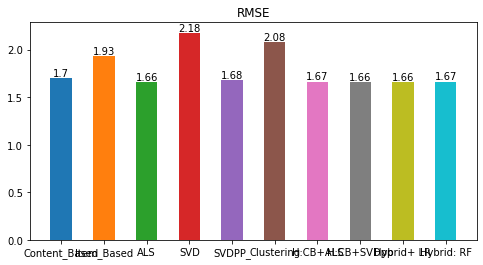

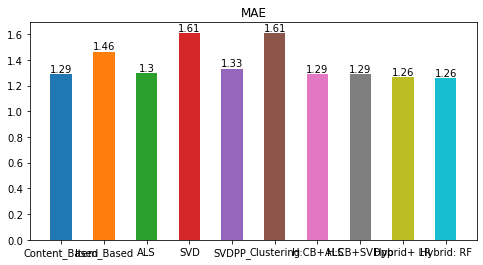

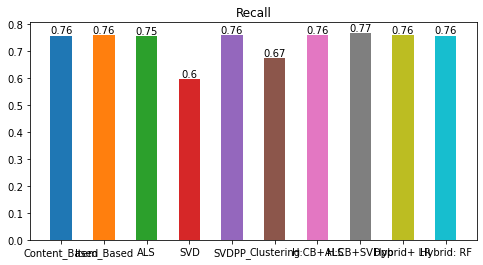

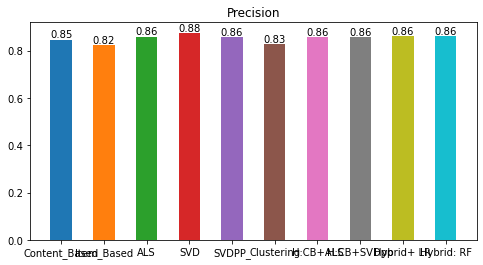

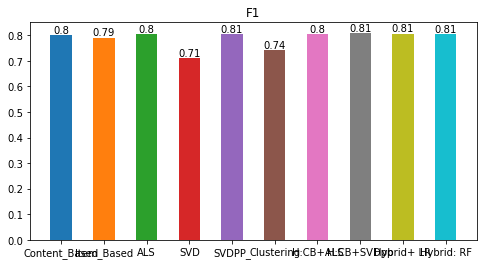

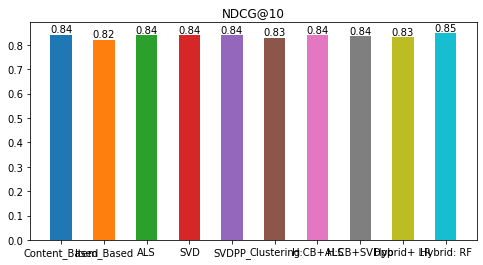

In [167]:
# simple visualization (Bar Chart)

import matplotlib.pyplot as plt

width = .5

for j, row in enumerate(overview.index):
    fig, ax = plt.subplots(figsize=(8,4))
    x = np.arange(len(overview.columns))
    for i, col in enumerate(overview.columns):
        plt.bar(x[i], overview.iloc[j,i], width, label='col')
        ax.text(x[i], overview.iloc[j,i], str(round(overview.iloc[j,i],2)),
                ha='center', va='bottom')
    ax.set_xticks(x)
    ax.set_title(row)
    ax.set_xticklabels(overview.columns)
    plt.show()

## Selected Model: ALS (BaselineOnly)

In [217]:
models = {"ALS":als_pred}
overview = pd.concat([eval.evaluate(mod, topn=10, rating_cutoff=5, excl_impossible=True) for mod in models.values()], axis=1)
overview.columns = list(models.keys())
overview.drop(labels=['Recall','Precision'], axis=0)

Excluded 0 (13925) samples. 13925 remaining ...
Excluded 0 (13925) samples. 13925 remaining ...


,ALS
RMSE,1.655654
MAE,1.297248
F1,0.803718
NDCG@10,0.840814


## Qualitative Assesment of recommendations

###### Defining Function to predict recommendations

In [168]:
def predict_user_topn(model, train, user, topk=15, item_col='item'):
    """
    Returns topk items for specified user.
    Return type: list

    Args[model, train, user, topk, item_col]
    model:      fitted model (surprise package)
    train:      train set used to fit model
    user:       user id
    topk:       topk items to return
    item_col:   column containing item ids 
    """

    # intermediate result dict 
    res = {item_col:[], 'pred':[], 'detail':[]}
    
    # iter through all items contained in train set
    for item in set(train[item_col]) :
        uid, iid, true_r, est, detail = model.predict(user,item)
        if detail['was_impossible']: continue
        # save to result dict
        res[item_col].append(item)
        res['pred'].append(est)
        res['detail'].append(detail)

    return list(pd.DataFrame(res).sort_values('pred', ascending=False)[:topk][item_col])

#### Recommendations for the selected Model: ALS

In [218]:
# Top 3 recommendations for user "66"

user = 2
topk = 10

res = {}
for model_name, model in dict(ALS=als).items():
    pred = predict_user_topn(model, train, user=user, topk=topk, item_col="artistID")
    # get name for each of the predicted product ids
    pred_name = [lookup_artistID.loc[i]["name"] for i in pred]
    res[model_name] = pred_name

pd.DataFrame(res)

,ALS
0,Tommy Lee
1,The Tiger Lillies
2,Renegade Five
3,Evading Downfall
4,Whitechapel
5,I Killed the Prom Queen
6,Jacques Brel
7,Tegan and Sara
8,Shaaman
9,Blur
